In [312]:
# CHANGE THESE PARAMETERS BEFORE RUNNING NOTEBOOK
######################
# main parameters of the datasets

# step; at which point the maze is steered; s=1 means that at the first step the maze is steer
s = 1 # s = [1,2,3,4..]

num_mazes    = 1   # 100 mazes
num_variants = 500  # 100 variants is too much?

coeff = 10

In [13]:
%env

[autoreload of unsearch_research.stable.utils.model_loading failed: Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/benjamin.berczi/Documents/GitHub/research/unsearch_research/stable/utils/model_loading.py", line 24, in <module>
    _WRITE_ONLY_JSER: JsonSerializer = JsonSerializer(wr

{'COMMAND_MODE': 'unix2003',
 'HOME': '/Users/benjamin.berczi',
 'HOMEBREW_CELLAR': '/opt/homebrew/Cellar',
 'HOMEBREW_PREFIX': '/opt/homebrew',
 'HOMEBREW_REPOSITORY': '/opt/homebrew',
 'INFOPATH': '/opt/homebrew/share/info:',
 'JAVA_HOME': '/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home',
 'LOGNAME': 'benjamin.berczi',
 'MANPATH': '/opt/homebrew/share/man::',
 'MallocNanoZone': '0',
 'OLDPWD': '/',
 'ORIGINAL_XDG_CURRENT_DESKTOP': 'undefined',
 'PATH': '/opt/homebrew/bin:/Users/benjamin.berczi/Library/Python/3.11/bin:/Users/benjamin.berczi/.pyenv/shims:/Users/benjamin.berczi/.rd/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Users/benjamin.berczi/.local/bin:/Users/benjamin.be

In [14]:
import os
PYTORCH_ENABLE_MPS_FALLBACK=1
CUDA_VISIBLE_DEVICES=""
os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

In [15]:
import sys
sys.path

sys.path.append("/Users/benjamin.berczi/Documents/maze-dataset")
sys.path.append("/Users/benjamin.berczi/Documents/maze-transformer-1")
sys.path.append("/Users/benjamin.berczi/Documents/GitHub/research")
sys.path.append("/Users/benjamin.berczi/Documents/GitHub/research/unsearch_research")

In [17]:
# Imports
%load_ext autoreload
%autoreload 2

# General Utilities
from pathlib import Path

# Generic ML
import numpy as np
import torch
from torch.utils.data import DataLoader
torch.set_float32_matmul_precision('medium') # if your GPU has TensorCores

# Maze Transformer and Dataset

# Other useful things
from muutils.nbutils.configure_notebook import configure_notebook
from unsearch_research import *

# other package imports
import matplotlib.pyplot as plt # keep this import for CI to work
from zanj import ZANJ # saving/loading data
from muutils.mlutils import pprint_summary # pretty printing as json

# maze_dataset imports

from maze_dataset import LatticeMaze, SolvedMaze, MazeDataset, MazeDatasetConfig
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.generation import LatticeMazeGenerators, GENERATORS_MAP
from maze_dataset.generation.default_generators import DEFAULT_GENERATORS
from maze_dataset.dataset.configs import MAZE_DATASET_CONFIGS
from maze_dataset.plotting import plot_dataset_mazes, print_dataset_mazes

from unsearch_research.stable.analysis import intervene_upon_generation

from matplotlib.gridspec import GridSpec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [262]:
from data_set_helpers import create_data_sets, create_directional_data_sets, create_data_sets_at_step_s,create_directional_data_sets_at_step_s
from steering_helpers import create_activation_vector, create_activation_vector_multiple, apply_act_vecs, apply_act_vecs_at_step_s, create_mean_vector_multiple, create_activation_vector_all_layers_multiple_mazes, create_mean_vector_all_layers_multiple_mazes, create_mean_vector_all_layers_multiple_mazes_at_step_s, create_activation_vector_all_layers_multiple_mazes_at_step_s
from eval_helpers import cast_sols_to_arrays, direction_to_diff, check_correct_steering, check_correct_end, check_correct_steering_at_step_s, plot_directional_heatmap, get_start_loc

In [19]:
# Configuration
SEED = 42
DARK_MODE = True
LOCAL_DATA_PATH = Path("/Users/benjamin.berczi/Documents")
#LOCAL_DATA_PATH: str = "../data/maze_dataset"

DEVICE = configure_notebook(
    seed=SEED,
    dark_mode=DARK_MODE,
    device=None,  # Defaults GPU > MPS > CPU
)
set_unsearch_style(dark_mode=DARK_MODE) # Matplotlib style

set up plots with PLOT_MODE = 'inline', FIG_OUTPUT_FMT = None, FIG_BASEPATH = None


In [20]:
model_run_id1 = "mixed_maze_sweep02_10-seed_1-lr_0.001-h_8-l_12-d_512-posembed_standard-20240210223618"
model_run_id2 = "mixed_maze_sweep02_12-seed_2-lr_0.0001-h_8-l_8-d_512-posembed_standard-20240212110545"
model_run_id3 = "mixed_maze_sweep02_10-seed_1-lr_0.0001-h_8-l_6-d_512-posembed_standard-20240210223546"
model_run_id4 = "mixed_maze_sweep02_10-seed_1-lr_0.0001-h_4-l_6-d_512-posembed_rotary-20240210223550" # canonical model

model, cfg = load_wandb_model(
    entity="aisc-search",
    project="mixed_maze_sweep",
    run_id=model_run_id4,
    # The following may be required for some older models with incomplete cfgs on wandb
    # you'll know because loading will complain about mismatched position embedding weights
    # config_overrides={"model_cfg": {"positional_embedding_type": "rotary"}},
    output_path=LOCAL_DATA_PATH / "downloaded_models",
)

Found a wandb context, but run_id is provided. Reconnecting to specified run


LinearProbes_1f6fa5bf54/train/total,0.27978
LinearProbes_1f6fa5bf54/val/total,0.67221
LinearProbes_9fb58882bc/train/total,2.34487
LinearProbes_9fb58882bc/val/total,0.62434
LinearProbes_acb70e40da/train/total,133.7373
LinearProbes_acb70e40da/val/total,0.51185
LinearProbes_baa170293c/train/total,12.75118
LinearProbes_baa170293c/val/total,0.55171
NewSparseAutoencoder_36305f024c/lr,0.0
NewSparseAutoencoder_36305f024c/sparsity_weight,1e-05
NewSparseAutoencoder_36305f024c/step,0


No wandb context found, creating one...


Found existing model.iter_24000000.pt in /Users/benjamin.berczi/Documents/downloaded_models/mixed_maze_sweep02_10-seed_1-lr_0.0001-h_4-l_6-d_512-posembed_rotary-20240210223550


In [313]:
# Load a dataset
tokenizer: MazeTokenizer = MazeTokenizer(tokenization_mode=TokenizationMode.AOTP_UT_rasterized, max_grid_size=7)

cfg = MazeDatasetConfig(
    name="test",
    grid_n=5,
    n_mazes=num_mazes,
    maze_ctor=LatticeMazeGenerators.gen_dfs,
    #maze_ctor_kwargs=dict(do_forks=False),

)

dataset = MazeDataset.from_config(
	cfg,
	load_local=True,
	do_generate=True,
    save_local=True,
	local_base_path=LOCAL_DATA_PATH / 'mazes',
	verbose=False,
)

In [314]:
dataset_right = []
dataset_left = []
dataset_up = []
dataset_down = []
dataset_mean = []

for data in dataset[:]:
	maze: SolvedMaze = data

	lattice_maze: LatticeMaze = LatticeMaze(
		connection_list=maze.connection_list,
		generation_meta=maze.generation_meta,
	)

	variants = create_data_sets_at_step_s(s, dataset, lattice_maze, num_variants)

	right, left = create_directional_data_sets_at_step_s(s, 'right', variants)
	up, down 	= create_directional_data_sets_at_step_s(s, 'up', 	 variants)

	dataset_right.append(right)
	dataset_left.append(left)
	dataset_up.append(up)
	dataset_down.append(down)

	dataset_mean.append(variants)


In [315]:
print("No. of right mazes: ",sum([len(x) for x in dataset_right]))
print("No. of left mazes: ",sum([len(x) for x in dataset_left]))
print("No. of up mazes: ",sum([len(x) for x in dataset_up]))
print("No. of down mazes: ",sum([len(x) for x in dataset_down]))

No. of right mazes:  20880
No. of left mazes:  19155
No. of up mazes:  19966
No. of down mazes:  23449


In [296]:

num_layers = 6
batch_size = 1
seq_length = 106 + s - 1
hidden_dim = 512

shape = torch.Size([batch_size, seq_length, hidden_dim])

In [297]:
mean_vecs = create_mean_vector_all_layers_multiple_mazes_at_step_s(s, tokenizer, model, DEVICE, dataset_mean, num_layers, shape)

Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5


In [298]:
act_vects_right = create_activation_vector_all_layers_multiple_mazes_at_step_s(s, tokenizer, model, DEVICE, dataset_right, dataset_left, num_layers, shape)
act_vects_up = create_activation_vector_all_layers_multiple_mazes_at_step_s(s, tokenizer, model, DEVICE, dataset_up, dataset_down, num_layers, shape)

Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5
Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5
Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5
Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5


In [299]:
act_vects_right_centred = []
act_vects_up_centred = []

for l in range(num_layers):
    act_vects_right_centred.append(act_vects_right[l] - mean_vecs[l])
    act_vects_up_centred.append(act_vects_up[l] - mean_vecs[l])

In [300]:
dirs = ['up','down','left', 'rigth']

In [301]:

def evaluate_steering_at_all_layers_in_direction(direction, s, tokenizer, model, DEVICE, dataset_neg, act_vects, pos_or_neg):
    map_steers = np.empty((num_layers, 5,5), dtype=object)
    map_ends = np.empty((num_layers, 5,5), dtype=object)

    map_steers_mean = np.zeros((num_layers, 5,5))
    map_ends_mean = np.zeros((num_layers, 5,5))
    map_steers_var = np.zeros((num_layers, 5,5))
    map_ends_var = np.zeros((num_layers, 5,5))

    if pos_or_neg == 'pos':
        sign = 1
    elif pos_or_neg == 'neg':
        sign = -1

    for l in range(num_layers):

        for i in range(5):
            for j in range(5):
                map_steers[l, i, j] = []
                map_ends[l, i, j] = []

        print(f"Starting layer {l}")
        for d in dataset_neg[:]:
            for maze in d:

                example = maze.as_tokens(tokenizer)

                start = get_start_loc(example)

                o,p = apply_act_vecs_at_step_s(s, tokenizer, model, DEVICE, sign*act_vects[l], l, coeff, example)

                oa = cast_sols_to_arrays(tokenizer, o)
                pa = cast_sols_to_arrays(tokenizer, p)

                steer = check_correct_steering_at_step_s(s, pa, direction)
                end   = check_correct_end(oa, pa)

                map_steers[l, start[0], start[1]].append(steer)
                map_ends[l, start[0], start[1]].append(end)

        for i in range(5):
            for j in range(5):
                if map_steers[l, i, j] != []:
                    map_steers_mean[l, i, j] = np.mean(map_steers[l, i, j])
                    map_ends_mean[l, i, j] = np.mean(map_ends[l, i, j])
                    map_steers_var[l, i, j] = np.var(map_steers[l, i, j])
                    map_ends_var[l, i, j] = np.var(map_ends[l, i, j])
                else:
                    map_steers_mean[l, i, j] = 0
                    map_ends_mean[l, i, j] = 0
                    map_steers_var[l, i, j] = 0
                    map_ends_var[l, i, j] = 0

    return map_steers_mean, map_steers_var, map_ends_mean, map_ends_var

In [302]:
steer_map_means1 = np.zeros((6,5,5,4))
end_map_means1 = np.zeros((6,5,5,4))
steer_map_vars1 = np.zeros((6,5,5,4))
end_map_vars1 = np.zeros((6,5,5,4))

steer_map_means2 = np.zeros((6,5,5,4))
end_map_means2 = np.zeros((6,5,5,4))
steer_map_vars2 = np.zeros((6,5,5,4))
end_map_vars2 = np.zeros((6,5,5,4))

In [303]:
steer_map_means1[:,:,:,0], steer_map_vars1[:,:,:,0], end_map_means1[:,:,:,0], end_map_vars1[:,:,:,0] = evaluate_steering_at_all_layers_in_direction('up', s, tokenizer, model, DEVICE, dataset_down, act_vects_up, 'pos')
steer_map_means1[:,:,:,1], steer_map_vars1[:,:,:,1], end_map_means1[:,:,:,1], end_map_vars1[:,:,:,1] = evaluate_steering_at_all_layers_in_direction('down', s, tokenizer, model, DEVICE, dataset_up, act_vects_up, 'neg')
steer_map_means1[:,:,:,2], steer_map_vars1[:,:,:,2], end_map_means1[:,:,:,2], end_map_vars1[:,:,:,2] = evaluate_steering_at_all_layers_in_direction('left', s, tokenizer, model, DEVICE, dataset_right, act_vects_right, 'neg')
steer_map_means1[:,:,:,3], steer_map_vars1[:,:,:,3], end_map_means1[:,:,:,3], end_map_vars1[:,:,:,3] = evaluate_steering_at_all_layers_in_direction('right', s, tokenizer, model, DEVICE, dataset_left, act_vects_right, 'pos')

Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5
Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5
Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5
Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5


In [304]:
steer_map_means2[:,:,:,0], steer_map_vars2[:,:,:,0], end_map_means2[:,:,:,0], end_map_vars2[:,:,:,0] = evaluate_steering_at_all_layers_in_direction('up', s, tokenizer, model, DEVICE, dataset_down, act_vects_up_centred, 'pos')
steer_map_means2[:,:,:,1], steer_map_vars2[:,:,:,1], end_map_means2[:,:,:,1], end_map_vars2[:,:,:,1] = evaluate_steering_at_all_layers_in_direction('down', s, tokenizer, model, DEVICE, dataset_up, act_vects_up_centred, 'neg')
steer_map_means2[:,:,:,2], steer_map_vars2[:,:,:,2], end_map_means2[:,:,:,2], end_map_vars2[:,:,:,2] = evaluate_steering_at_all_layers_in_direction('left', s, tokenizer, model, DEVICE, dataset_right, act_vects_right_centred, 'neg')
steer_map_means2[:,:,:,3], steer_map_vars2[:,:,:,3], end_map_means2[:,:,:,3], end_map_vars2[:,:,:,3] = evaluate_steering_at_all_layers_in_direction('right', s, tokenizer, model, DEVICE, dataset_left, act_vects_right_centred, 'pos')

Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5
Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5
Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5
Starting layer 0
Starting layer 1
Starting layer 2
Starting layer 3
Starting layer 4
Starting layer 5


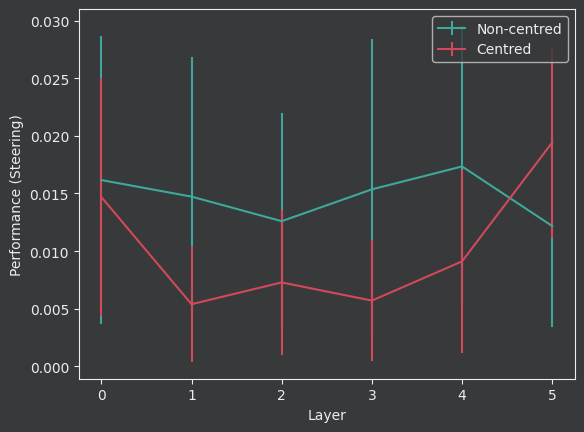

In [305]:
layers = np.linspace(0, num_layers - 1, num_layers, dtype=int)

plt.errorbar(layers, steer_map_means1.mean(axis=3).mean(axis=2).mean(axis=1), steer_map_vars1.mean(axis=3).mean(axis=2).mean(axis=1), label='Non-centred')
plt.errorbar(layers, steer_map_means2.mean(axis=3).mean(axis=2).mean(axis=1), steer_map_vars2.mean(axis=3).mean(axis=2).mean(axis=1), label='Centred')

plt.xlabel('Layer')
plt.ylabel('Performance (Steering)')
plt.legend();

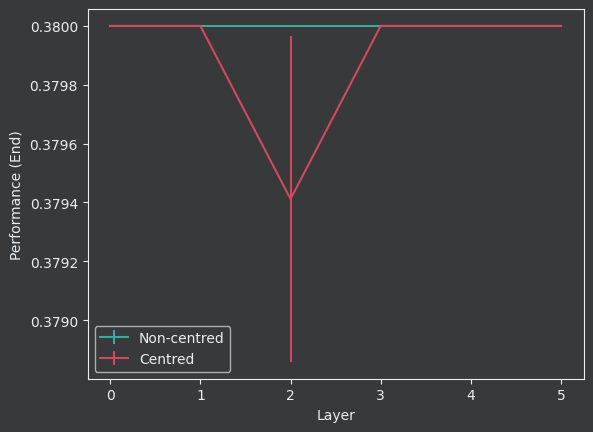

In [306]:
plt.errorbar(layers, end_map_means1.mean(axis=3).mean(axis=2).mean(axis=1), end_map_vars1.mean(axis=3).mean(axis=2).mean(axis=1), label='Non-centred')
plt.errorbar(layers, end_map_means2.mean(axis=3).mean(axis=2).mean(axis=1), end_map_vars2.mean(axis=3).mean(axis=2).mean(axis=1), label='Centred')

plt.xlabel('Layer')
plt.ylabel('Performance (End)')
plt.legend();

In [316]:
# distribution of maze starting points on the grid

grid_start = np.zeros((5,5,4))

for d in dataset_up:
    for maze in d:
        start = get_start_loc(maze.as_tokens(tokenizer))
        grid_start[start[0], start[1], 0] += 1

for d in dataset_down:
    for maze in d:
        start = get_start_loc(maze.as_tokens(tokenizer))
        grid_start[start[0], start[1], 1] += 1

for d in dataset_left:
    for maze in d:
        start = get_start_loc(maze.as_tokens(tokenizer))
        grid_start[start[0], start[1], 2] += 1

for d in dataset_right:
    for maze in d:
        start = get_start_loc(maze.as_tokens(tokenizer))
        grid_start[start[0], start[1], 3] += 1

(<Figure size 800x800 with 2 Axes>, <Axes: >)

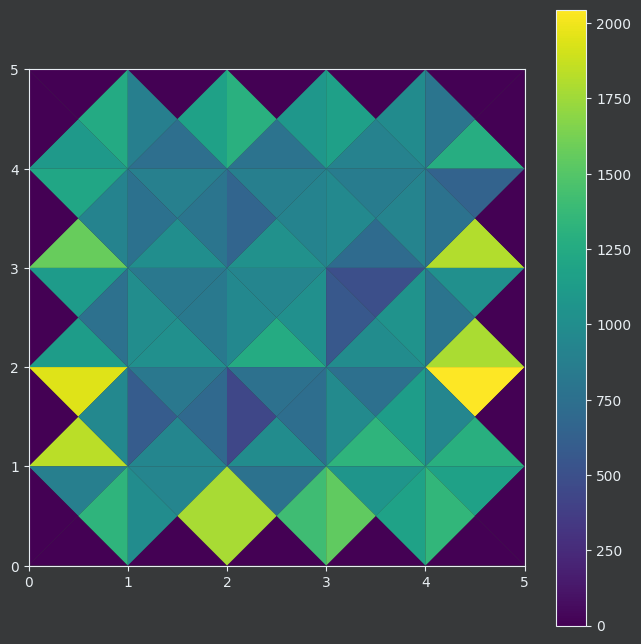

In [317]:
plot_directional_heatmap(grid_start)

In [318]:
grid_start

array([[[   0., 1098.,    0., 1242.],
        [   0.,  742.,  875., 1173.],
        [   0.,  775., 1300., 1084.],
        [   0.,  906., 1158.,  981.],
        [   0., 1274.,  791.,    0.]],

       [[1207., 1573.,    0.,  916.],
        [ 881., 1005.,  763.,  791.],
        [ 877., 1027.,  663.,  918.],
        [ 851.,  704.,  959.,  926.],
        [ 644., 1806.,  770.,    0.]],

       [[1115., 1126.,    0.,  756.],
        [ 817., 1016.,  995.,  826.],
        [ 934., 1254.,  956., 1021.],
        [ 493.,  984.,  556., 1048.],
        [1022., 1783.,  784.,    0.]],

       [[1946., 1830.,    0.,  954.],
        [ 819.,  940.,  588.,  687.],
        [ 758.,  986.,  439.,  733.],
        [ 747., 1329.,  968., 1132.],
        [2045., 1291.,  939.,    0.]],

       [[ 874.,    0.,    0., 1334.],
        [ 927.,    0.,  985., 1774.],
        [ 771.,    0., 1776., 1409.],
        [1064.,    0., 1544., 1175.],
        [1174.,    0., 1346.,    0.]]])

(<Figure size 800x800 with 2 Axes>, <Axes: >)

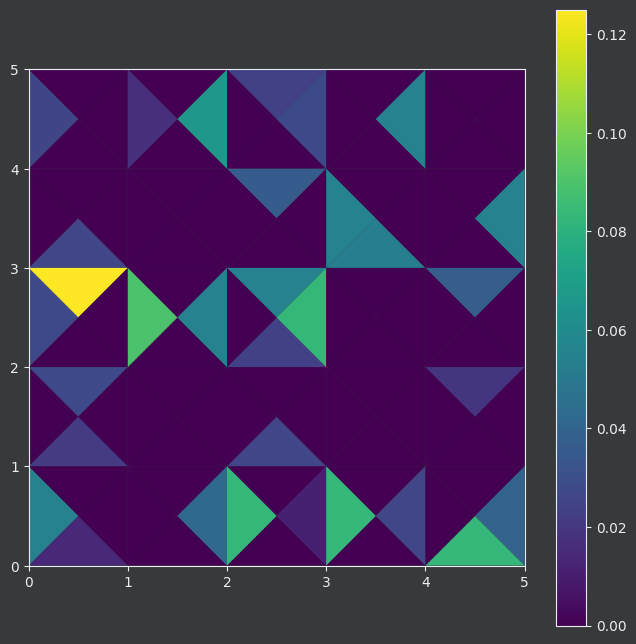

In [309]:
plot_directional_heatmap(steer_map_means1.mean(axis=0))

(<Figure size 800x800 with 2 Axes>, <Axes: >)

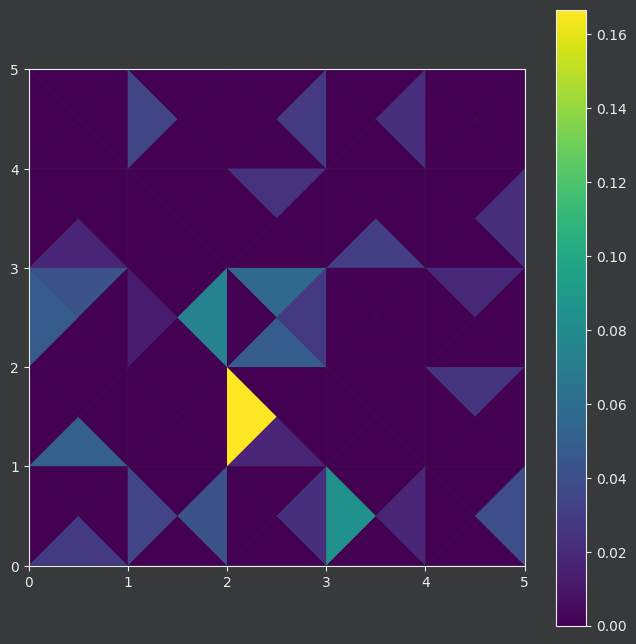

In [310]:
plot_directional_heatmap(steer_map_means2.mean(axis=0))